## Importing Relevant Libraries

In [2]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding, Flatten
from tensorflow.keras.preprocessing.text import one_hot
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [3]:
data = pd.read_csv('nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Analysis

*   there are 7613 data points.
*   **99.198739%** of the data has **keywords**.
*   **66.73%** of the data has **location** points
*   the top key word used to extract tweets is **fatalities**.
*   data is ordered in terms of keyword used to extact the tweet from twitter.

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.
*   keyword and location features were dropped as they add no significant value to the model performance.


### Data Cleaning

In [4]:
nltk.download('stopwords')
#### removing entries where location values are missing
data_after_null_removal = data.copy()
# data_after_null_removal = data_after_null_removal.dropna(subset=['location'])

#punctutation removal
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: remove_punct(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearby homes httptcostfmbbzfb,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires california even northern part state troubling,1
7610,10871,NaN,NaN,utckm volcano hawaii httptcozdtoydebj,1
7611,10872,NaN,NaN,police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...,1


In [5]:
### train - test split
training, testing = train_test_split(data_without_tockenization, test_size=0.1, random_state=42, shuffle=True)

In [6]:
train = training.copy()
test = testing.copy()
# get the dependent and independent variables
train_x = train['text']
train_y = train['target']
test_x = test['text']
test_y = test['target']

### Preprocessing

In [7]:
train_x = np.array(train_x)
train_y = np.array(train_y)


# only work with the 30000 most popular words found in our dataset
max_words = 30000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('./Dictionary_Models/keras_dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

# Function to convert the text to its corresponding index
def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

############################

# Embedding Representation

############################
# Padding each text so that it has the same length
text_length = 27
embedded_text = pad_sequences(allWordIndices, padding='pre', maxlen=text_length)

train_x = np.asarray(embedded_text)
train_y = keras.utils.to_categorical(train_y, 2)

### Model

In [8]:
# Creating a model
embedding_features = 32
model = Sequential()
model.add(Embedding(input_dim=max_words,output_dim=embedding_features, input_length=text_length))
model.add(Flatten())
model.add(Dense(30, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(30,activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

print(model.summary())

history = model.fit(train_x, train_y,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('./NN_Models/embeddingModel.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('./NN_Models/embeddingModel.h5')

print('saved model!')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 32)            960000    
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                25950     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 986,942
Trainable params: 986,942
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
193/193 [==============================] - 4s 19ms/step - loss: 0.6206 - accuracy: 0.6561 - val_loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


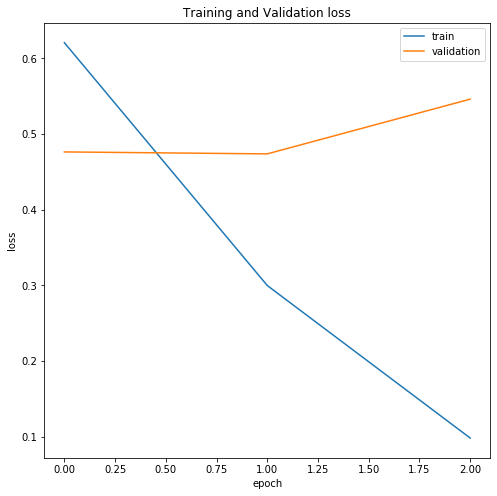

In [9]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Testing Model

In [10]:
labels = ['fake', 'real']

# read in our saved dictionary
with open('./Dictionary_Models/keras_dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])

    return wordIndices

# read in your saved model structure
json_file = open('./NN_Models/embeddingModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# and create a model from that
model = model_from_json(loaded_model_json)
# and weight your nodes with your saved values
model.load_weights('./NN_Models/embeddingModel.h5')

text_sequence = []

for index_of_interest, text1 in enumerate(test_x):
    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    text_sequence.append(testArr)
    
padded_sequence = pad_sequences(text_sequence, padding='pre', maxlen=text_length)
predictions_before_formatting = model.predict(padded_sequence)

predictions = []
for num in predictions_before_formatting:
  predictions.append(np.argmax(num))
#end for

In [11]:
def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in predictions]

In [12]:
predictions = np.array(predictions)
test_y = np.array(test_y)
confusion_matrix(test_y, predictions)

tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn +tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1_score = 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1_score], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,366,60
Positive,124,212


In [13]:
results

,Value
Accuracy,0.758530
Precision,0.779412
FPR,0.140845
Recall,0.630952
F1,0.697368


### Summary of Keras Embedding Layer
- The highest achievable accuracy is 77%.
- F1 score is 0.7.
- Recall and Precision are 61% and 82% respectively.
- Model starts overfitting on the 4-5th epoch.
- Validation loss never goes below ~0.46.
- Best performance is at batch size of 32.
- The base model seems to be better than this in terms of accuracy.